In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [2]:
# specimen_id = 476686112
# model_type = 'perisomatic'#or 'all active'
# work_dir = 'OriginalFromAllenDB'

In [2]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
# sys.path.append("ACT")
# from act.passive import ACTPassiveModule

In [3]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils

In [5]:
# bp = BiophysicalApi()#using AllenDB's API
# models = bp.get_neuronal_models(specimen_id)

# for model in models:
#   if model_type in model['name'].lower():
#     print(f"model id = {model['id']}\n")
#     model_id = model['id']
# models

In [6]:
# Download the cell
# bp.cache_stimulus = False # Change to False to not download the large stimulus NWB file
# bp.cache_data(model_id, working_directory = work_dir )
# os.chdir(work_dir)

In [4]:
def build_cell(soma_diam_multiplier = 1,using_hoc=False,hoc_filename=None,cell_name=None):

    if using_hoc:
      from neuron import h
      h.load_file(hoc_filename)
      return getattr(h, cell_name)()
    # Create the h object
    description = Config().load('manifest.json')
    utils = Utils(description)
    h = utils.h
    # Convert all "value" attributes to floats
    for dict in utils.description.data['genome']:
        for key, value in dict.items():
            if key == 'value': dict[key] = float(value)
    # Configure morphology
    morphology_path = description.manifest.get_path('MORPHOLOGY')
    utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
    utils.load_cell_parameters()
    # To match PP
    h.soma[0].diam = h.soma[0].diam * soma_diam_multiplier

    return h

def set_simulation(hoc_object,sim_params, soma_diam_multiplier = 1.0):
    from neuron import h
    h.load_file("stdrun.hoc")
    stim = h.IClamp(hoc_object.soma[0](0.5))
    stim.amp = sim_params['stim_amp']
    stim.delay = sim_params['stim_delay']
    stim.dur = sim_params['stim_dur']
    h.tstop = sim_params['h_tstop']
    h.dt = sim_params['h_dt']
    # h.steps_per_ms = 1 / h.dt
    return h, stim

In [5]:
os.chdir('OriginalFromAllenDB')

In [6]:
!nrnivmodl modfiles

/home/dpd4k4/repos/binocular_integration/OriginalFromAllenDB
Mod files: "modfiles/modfiles/AMPA_NMDA_STP.mod" "modfiles/modfiles/CaDynamics.mod" "modfiles/modfiles/Ca_HVA.mod" "modfiles/modfiles/Ca_LVA.mod" "modfiles/modfiles/Ih.mod" "modfiles/modfiles/Im.mod" "modfiles/modfiles/Im_v2.mod" "modfiles/modfiles/K_P.mod" "modfiles/modfiles/K_T.mod" "modfiles/modfiles/Kd.mod" "modfiles/modfiles/Kv2like.mod" "modfiles/modfiles/Kv3_1.mod" "modfiles/modfiles/NMDAIN.mod" "modfiles/modfiles/NaTa.mod" "modfiles/modfiles/NaTs.mod" "modfiles/modfiles/NaV.mod" "modfiles/modfiles/Nap.mod" "modfiles/modfiles/SK.mod" "modfiles/modfiles/cpampain.mod" "modfiles/modfiles/gabaain.mod" "modfiles/modfiles/vecstim.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [7]:
soma_diam_multiplier = 1
hobject = build_cell(soma_diam_multiplier)

In [22]:
print(f"Soma area: {hobject.soma[0](0.5).area()}")
print(f"Soma diam: {hobject.soma[0].diam}")
print(f"Soma L: {hobject.soma[0].L}")

Soma area: 503.6323076932052
Soma diam: 12.661399841308594
Soma L: 12.661407470703125


In [23]:
# Soma area from the previous cell
computed_soma_area = hobject.soma[0](0.5).area() * 1e-8 #(cm2)
# User-provided desired properties
user_provided_Rin = 195.4 * 10e6 # (to Ohm from MOhm)
user_provided_tau = 15.6 * 1e-3 # (to s from ms)
user_provided_Vrest = -71 # (mV)
spps = ACTPassiveModule.compute_spp(user_provided_Rin, computed_soma_area, user_provided_tau, user_provided_Vrest)
print(spps)

SettablePassiveProperties(Cm=1.5852087355778763, g_bar_leak=0.00010161594458832541, e_rev_leak=-71, g_bar_h=None)


In [24]:

import json

for item in os.listdir():
  if item.endswith('_fit.json'):
    config_filename = item
    print(config_filename)

with open(os.path.join(config_filename),'r') as file:
    data = json.load(file)

#save the original data
original_fit = {
                'cm':None,
                'g_pas':None,
                'e_pas':None
                }
# data in the passive section
for item in data['passive'][0]['cm']:
  original_fit['cm'] = item['cm']

original_fit['e_pas'] = data['passive'][0]['e_pas']


# data in the active "genome" section
for item in data['genome']:

  if item['name'] == 'g_pas':
    original_fit['g_pas'] = item['value']

  if item['name'] == 'cm':
    original_fit['cm'] = item['value']


#set new parameters
new_fit = {
            'cm':spps.Cm,
            'g_pas':spps.g_bar_leak,
            'e_pas':spps.e_rev_leak
            }

476686112_fit.json


In [37]:
#choose new_fit or original_fit for the _fit.json file
###############################
chosen_fit = original_fit
###############################
for item in data['passive'][0]['cm']:
  item['cm'] = chosen_fit['cm']

data['passive'][0]['e_pas'] = chosen_fit['e_pas']

for item in data['genome']:

  if item['name'] == 'g_pas':
    item['value'] = chosen_fit['g_pas']

  if item['name'] == 'cm':
    item['value'] = chosen_fit['cm']

with open(config_filename, 'w') as file:
    json.dump(data, file, indent=4)

In [38]:
sim_params = {
                'stim_amp': -0.1,
                'stim_delay': 100,
                'stim_dur': 1000,
                'h_tstop': 1200,
                'h_dt': 0.025
                }

In [39]:
def count_voltage_events(t, v):
    """
    Counts the number of times the voltage goes above -20 mV and the slope changes from positive to negative.

    Args:
        t: A NumPy array of time points.
        v: A NumPy array of voltage values.

    Returns:
        The number of events.
    """

    # Calculate the slope of the voltage
    slope = np.diff(v)

    # Find the indices where the voltage is above -20 mV
    above_threshold_indices = np.where(v[:-1] > -20)[0]

    # Find the indices where the slope changes from positive to negative
    positive_to_negative_indices = np.where((slope[:-1] > 0) & (slope[1:] < 0))[0]

    # Find the intersection of the two sets of indices
    event_indices = np.intersect1d(above_threshold_indices, positive_to_negative_indices)

    return len(event_indices)

In [40]:
#function to get the start and end index of the stim but in the voltage file
def get_start_end_idx(sim_params):
  start_idx = int(sim_params['stim_delay']/sim_params['h_dt'])
  end_idx = int(sim_params['stim_dur']/sim_params['h_dt'])
  return start_idx, end_idx

In [41]:
#function to calculate the frequency of a voltage trace
def get_frequency(v,sim_params):

  start_idx,end_idx = get_start_end_idx(sim_params)
  spikes = count_voltage_events(np.arange(len(v.as_numpy()))[start_idx:end_idx], v.as_numpy()[start_idx:end_idx])

  if spikes> 0:
    duration_sec = sim_params['stim_dur'] / 1000.0
    freq = spikes / duration_sec
    return freq

  else:
    return 0

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


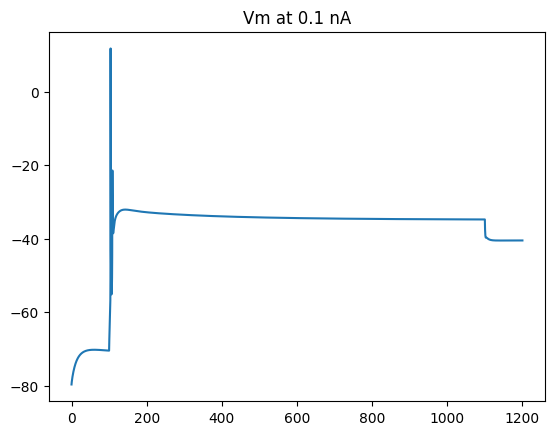

spike frequency = 1.00 Hz


In [43]:
#modify simulation parameters if needed
sim_params['stim_amp'] = 0.1

#rebuild the cell to make sure the set_simulation() is using the correct hobj
#if using hoc call with the hoc filename and cell name

soma_diam_multiplier = 1
hobject = build_cell(soma_diam_multiplier)
#hobject = build_cell(soma_diam_multiplier,using_hoc=True,'HYPO_TEMPLATE.hoc','HYPO')

# run the simulation
h, stim = set_simulation(hobject,sim_params)
v = h.Vector().record(hobject.soma[0](0.5)._ref_v)
h.finitialize()
h.run()

#plot the result and display spike frequency
V = v.as_numpy()
T = np.arange(0,h.tstop+h.dt,h.dt)
plt.plot(T,V)
plt.title(f"Vm at {sim_params['stim_amp']} nA")
plt.show()

print(f"spike frequency = {get_frequency(v,sim_params):.2f} Hz")

In [36]:
print(ACTPassiveModule.compute_gpp(v.as_numpy(), h.dt, sim_params['stim_delay'], h.tstop, sim_params['stim_amp']))
print(f"V-rest: {v.as_numpy()[sim_params['stim_dur']]}")

GettablePassiveProperties(R_in=231.33298179751492, tau1=8.35, tau2=971.4250000000001, sag_ratio=1.0366001579094744, V_rest=-70.45206401772245)
V-rest: -71.34179096366036


In [ ]:
frequenies = []
amps = [-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]


for amp in amps:
  #if using hoc call with the hoc filename and cell name
    hobject = build_cell(soma_diam_multiplier)
    #hobject = build_cell(soma_diam_multiplier,using_hoc=True,'HYPO_TEMPLATE.hoc','HYPO')

    sim_params['stim_amp'] = amp
    h, stim = set_simulation(hobject,sim_params)
    v = h.Vector().record(hobject.soma[0](0.5)._ref_v)
    h.finitialize()
    h.run()
    frequenies.append(get_frequency(v,sim_params))


warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768
warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root

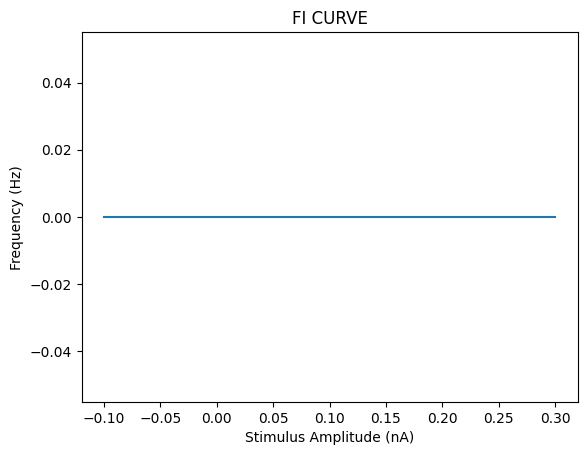

In [ ]:
plt.plot(amps, frequenies)
plt.title("FI CURVE")
plt.xlabel("Stimulus Amplitude (nA)")
plt.ylabel("Frequency (Hz)")
plt.show()